# Anomaly detection and clustering patterns in marketing data
In this notebook, we will be implementing Nearest Neighbors and K means clustering to find the relationship between income level and total spending

In [1]:
# Basic Libraries
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt # we only need pyplot

## Importing the Dataset

In [2]:
marketdata = pd.read_csv("marketing_data.csv")
marketdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 28 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ID                   2240 non-null   int64 
 1   Year_Birth           2240 non-null   int64 
 2   Education            2240 non-null   object
 3   Marital_Status       2240 non-null   object
 4    Income              2216 non-null   object
 5   Kidhome              2240 non-null   int64 
 6   Teenhome             2240 non-null   int64 
 7   Dt_Customer          2240 non-null   object
 8   Recency              2240 non-null   int64 
 9   MntWines             2240 non-null   int64 
 10  MntFruits            2240 non-null   int64 
 11  MntMeatProducts      2240 non-null   int64 
 12  MntFishProducts      2240 non-null   int64 
 13  MntSweetProducts     2240 non-null   int64 
 14  MntGoldProds         2240 non-null   int64 
 15  NumDealsPurchases    2240 non-null   int64 
 16  NumWeb

## Data Preprocessing
There are a few things that we have to clean up in this dataset
1. Rename some column names for easier access (i.e. income has a space infront of its name)

2. Check for duplicated data and drop them 

3. Check and handle missing data

4. Drop irrelevant data

In [3]:
# Rename some columns for easier access
#Remove the spaces in the "income" column name
marketdata.columns = marketdata.columns.map(lambda x : x.replace(" ", ""))
marketdata.rename(columns = {"Dt_Customer":"Date"},inplace = True)
marketdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 28 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ID                   2240 non-null   int64 
 1   Year_Birth           2240 non-null   int64 
 2   Education            2240 non-null   object
 3   Marital_Status       2240 non-null   object
 4   Income               2216 non-null   object
 5   Kidhome              2240 non-null   int64 
 6   Teenhome             2240 non-null   int64 
 7   Date                 2240 non-null   object
 8   Recency              2240 non-null   int64 
 9   MntWines             2240 non-null   int64 
 10  MntFruits            2240 non-null   int64 
 11  MntMeatProducts      2240 non-null   int64 
 12  MntFishProducts      2240 non-null   int64 
 13  MntSweetProducts     2240 non-null   int64 
 14  MntGoldProds         2240 non-null   int64 
 15  NumDealsPurchases    2240 non-null   int64 
 16  NumWeb

In [4]:
# Change the date to a date time format
marketdata["Date"]= pd.to_datetime(marketdata["Date"], format = "%m/%d/%y")
# Format the income column to remove "$" and ","
marketdata["Income"] = marketdata["Income"].str.replace("$","")
marketdata["Income"] = marketdata["Income"].str.replace(",","")
# Convert to float type
marketdata["Income"] = marketdata["Income"].astype(float)
marketdata.head()

<ipython-input-4-aee56446e9d3>:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  marketdata["Income"] = marketdata["Income"].str.replace("$","")


,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Date,Recency,MntWines,...,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Response,Complain,Country
0,1826,1970,Graduation,Divorced,84835.0,0,0,2014-06-16,0,189,...,6,1,0,0,0,0,0,1,0,SP
1,1,1961,Graduation,Single,57091.0,0,0,2014-06-15,0,464,...,7,5,0,0,0,0,1,1,0,CA
2,10476,1958,Graduation,Married,67267.0,0,1,2014-05-13,0,134,...,5,2,0,0,0,0,0,0,0,US
3,1386,1967,Graduation,Together,32474.0,1,1,2014-05-11,0,10,...,2,7,0,0,0,0,0,0,0,AUS
4,5371,1989,Graduation,Single,21474.0,1,0,2014-04-08,0,6,...,2,7,1,0,0,0,0,1,0,SP


In [5]:
# Check for missing data
marketdata.isnull().sum()

ID                      0
Year_Birth              0
Education               0
Marital_Status          0
Income                 24
Kidhome                 0
Teenhome                0
Date                    0
Recency                 0
MntWines                0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntSweetProducts        0
MntGoldProds            0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
AcceptedCmp3            0
AcceptedCmp4            0
AcceptedCmp5            0
AcceptedCmp1            0
AcceptedCmp2            0
Response                0
Complain                0
Country                 0
dtype: int64

There are 24 rows where the income is not filled in, we will be dropping these data as they are not useful in our analysis

In [6]:
# Drop the rows with null income as they will not be useful
marketdata = marketdata.dropna()
marketdata.shape

(2216, 28)

In [7]:
# Remove irrelevant data
# We will be dropping everything except income and amount spent on products
marketdata = marketdata.drop(columns = ["ID","Year_Birth","Education","Marital_Status","Kidhome","Teenhome","Recency","Response","Complain","Country"
                           ,"AcceptedCmp1","AcceptedCmp2","AcceptedCmp3","AcceptedCmp4","AcceptedCmp5"
                           ,"NumDealsPurchases","NumWebPurchases","NumCatalogPurchases","NumStorePurchases","NumWebVisitsMonth","Date"])

In [8]:
# Add Mnt columns to get the total amount spent on products
marketdata["TotalSpent"] = marketdata["MntWines"] + marketdata["MntFruits"] + marketdata["MntMeatProducts"] + marketdata["MntFishProducts"] + marketdata["MntSweetProducts"] + marketdata["MntGoldProds"]
marketdata.head()

,Income,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,TotalSpent
0,84835.0,189,104,379,111,189,218,1190
1,57091.0,464,5,64,7,0,37,577
2,67267.0,134,11,59,15,2,30,251
3,32474.0,10,0,1,0,0,0,11
4,21474.0,6,16,24,11,0,34,91


# Basic Exploration
We will be exploring the income and the number of store purchases

<AxesSubplot:xlabel='TotalSpent', ylabel='Count'>

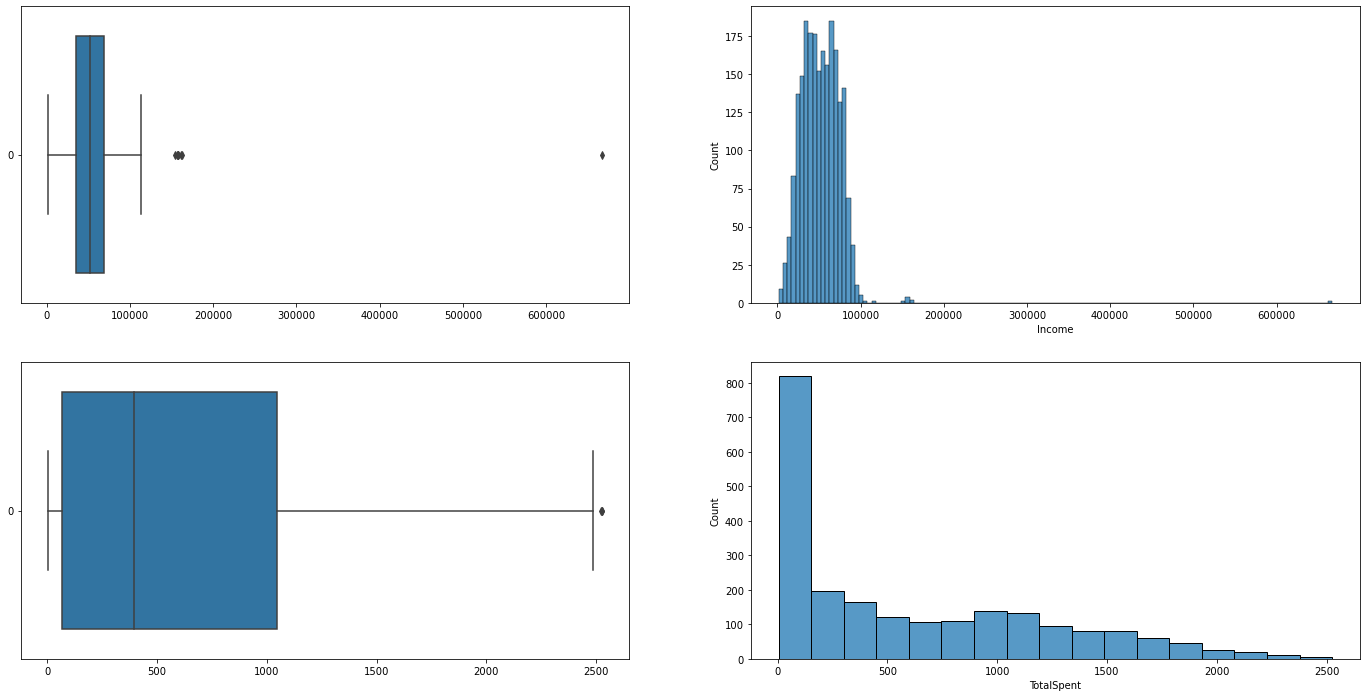

In [9]:
# Plotting univariate graphs for Income and NumStorePurchases
# Set up matplotlib figure subplots
f, axes = plt.subplots(2, 2, figsize=(24, 12))

# Plotting Income
sb.boxplot(data = marketdata["Income"], orient = "h", ax = axes[0,0])
sb.histplot(data = marketdata["Income"], ax = axes[0,1])

sb.boxplot(data = marketdata["TotalSpent"], orient = "h", ax = axes[1,0])
sb.histplot(data = marketdata["TotalSpent"], ax = axes[1,1])



We can see from these plots that the income is largely skewed with most of the data within the range of 0-100000, with a few outliers. While the totalspent plots are relatively evenly distributed though still largely skewed to the left.

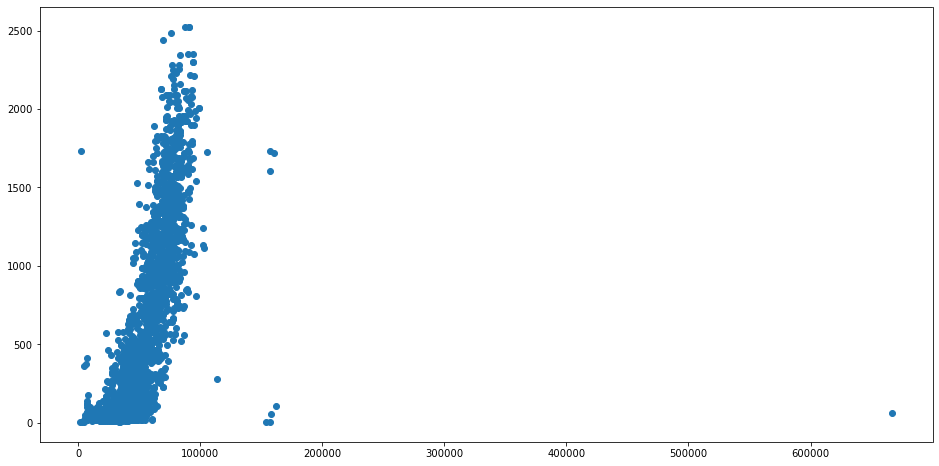

In [10]:
# Extract the Features from the Data
X = pd.DataFrame(marketdata[["Income", "TotalSpent"]])

# Plot the Raw Data on a 2D grid
f, axes = plt.subplots(1, 1, figsize=(16,8))
plt.scatter(x = "Income", y = "TotalSpent", data = X)

# Anomaly Detection using Nearest Neighbours

Since Extreme Anomalies exist in the dataset, it would be useful to identify them before clustering them to get a more fruitful analysis of the dataset.

The concept behind nearest neighbours is to find a predetermined number of samples closest to a point, and label them.

In this case we will be using nearest neighbours to identify outliers in order to remove them from the data set. The predetermined number of neighbors will be estimated at 10, and the fraction of Anomalies with respect to the total data will be 2%

In [11]:
# Import LocalOutlierFactor from sklearn.neighbors
from sklearn.neighbors import LocalOutlierFactor

# Set the Parameters for Neighborhood
num_neighbors = 10      # Number of Neighbors
cont_fraction = 0.02    # Fraction of Anomalies with respect to the total data

# Create Anomaly Detection Model using LocalOutlierFactor
lof = LocalOutlierFactor(n_neighbors = num_neighbors, contamination = cont_fraction)

# Fit the Model on the Data and Predict Anomalies.
# Predict a label anomaly
lof.fit(X)

LocalOutlierFactor(contamination=0.02, n_neighbors=10)

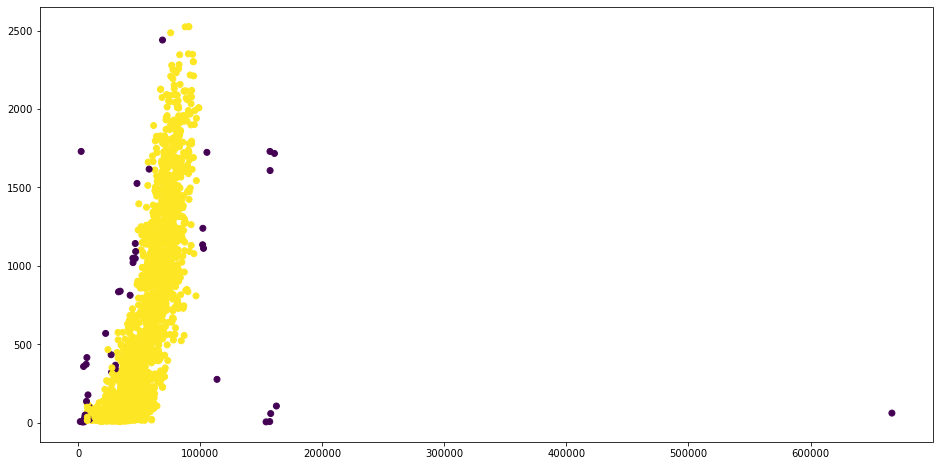

In [12]:
# Visualize the Anomalies in the Data
# Predict the Anomalies
# lof is local oultier factor
labels = lof.fit_predict(X)

# Append Labels to the Data
X_labeled_Anomaly = X.copy()
X_labeled_Anomaly["Anomaly"] = pd.Categorical(labels)
f, axes = plt.subplots(1, 1, figsize=(16,8))
plt.scatter(x = "Income", y = "TotalSpent",c ='Anomaly', cmap = 'viridis', data = X_labeled_Anomaly)

From the graph, given the labels, it becomes quite obvious that these points are not part of the clustered yellow dataset, as such we will be dropping them in order to have a more fruitful analyse of the dataset

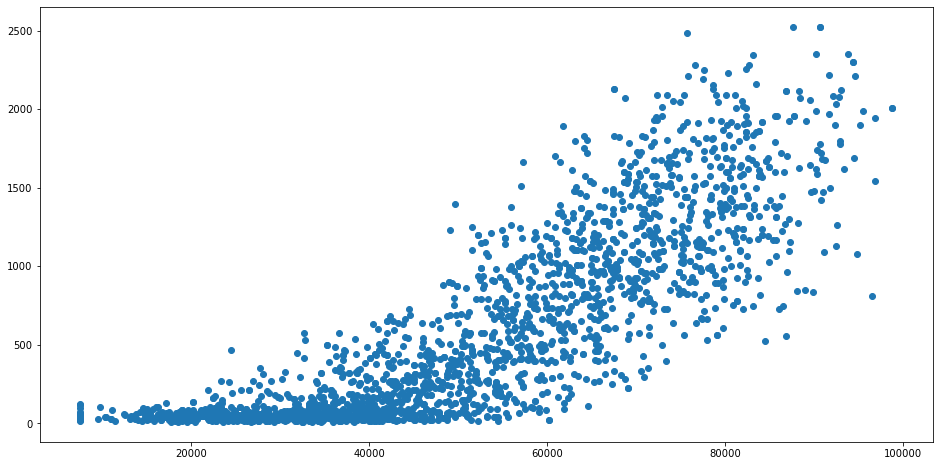

In [13]:
# Iterate through the rows and find which are the anomalies
for index,row in X_labeled_Anomaly.iterrows():
    # -1 are all the anomalies
    if row["Anomaly"] == -1:
        # Drop all the anomalies to "clean the data"
        X_labeled_Anomaly = X_labeled_Anomaly.drop(index)

# Plot the "Cleaned" data for visualization
f, axes = plt.subplots(1, 1, figsize=(16,8))        
plt.scatter(x = "Income", y = "TotalSpent", cmap = 'viridis', data = X_labeled_Anomaly)

With the anomalies dropped, we are able to get a better sense of the relationship between income and TotalSpent at the store

# Implementing Bi-Variate K-Means Clustering

K means clustering goes through these following steps
1. Choose the number of clusters K
2. Select K number of points randomly as centroids
3. Assign all points to the cluster centroid by comparing distances away from the centroid
4. Calculate the "total distance" away from the centroid
5. Repeat steps 3 and 4 until the total distance from the centroid is minimized.

We will be using the "elbow plot" method to determine K

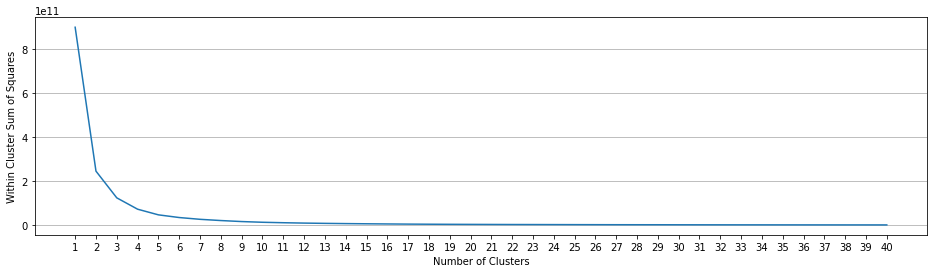

In [14]:
# Import KMeans from sklearn.cluster
from sklearn.cluster import KMeans

# Extract the Features from the Data
X = X_labeled_Anomaly

# Vary the Number of Clusters
min_clust = 1
max_clust = 40

# Compute Within Cluster Sum of Squares
# For each number of clusters, calculate the k nmeans and append it to a list, then plot the list
within_ss = []
for num_clust in range(min_clust, max_clust+1):
    kmeans = KMeans(n_clusters = num_clust)
    kmeans.fit(X)
    within_ss.append(kmeans.inertia_)

# Plot Within SS vs Number of Clusters
f, axes = plt.subplots(1, 1, figsize=(16,4))
plt.plot(range(min_clust, max_clust+1), within_ss)
plt.xlabel('Number of Clusters')
plt.ylabel('Within Cluster Sum of Squares')
plt.xticks(np.arange(min_clust, max_clust+1, 1.0))
plt.grid(which='major', axis='y')
plt.show()

From this "Elbow" Plot, you can tell that the last elbow bend seems to come at K = 4 clusters

Features 	Income 	TotalSpent

Cluster 0:	41463.72	197.92	1.0	
Cluster 1:	78865.0	1383.07	1.0	
Cluster 2:	23892.03	66.04	1.0	
Cluster 3:	60400.01	765.5	1.0	


/Users/loissen/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


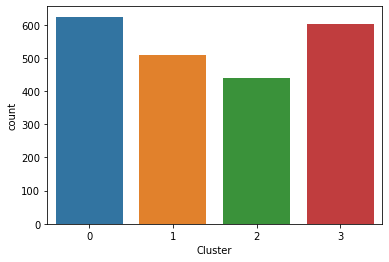

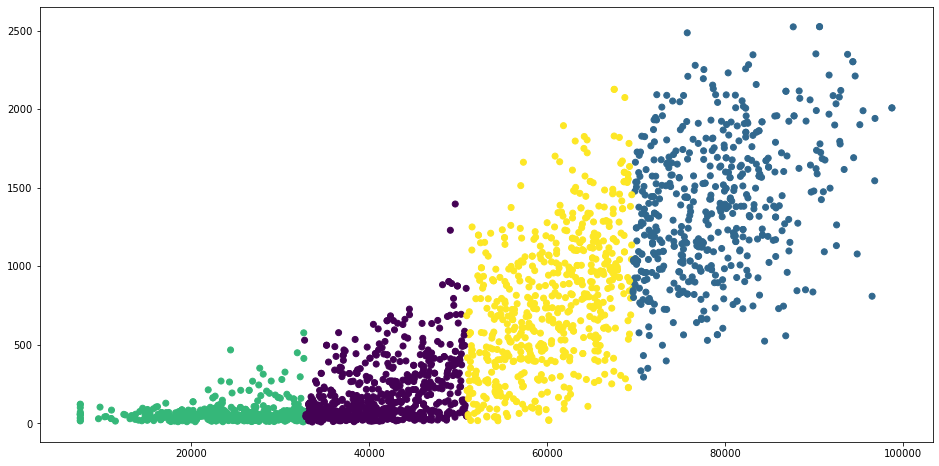

In [15]:
# Guess the Number of Clusters
num_clust = 4

# Create Clustering Model using KMeans
kmeans = KMeans(n_clusters = num_clust)

# Fit the Clustering Model on the Data
kmeans.fit(X)

# Print the Cluster Centers
print("Features", "\tIncome", "\tTotalSpent")
print()

for i, center in enumerate(kmeans.cluster_centers_):
    print("Cluster", i, end=":\t")
    for coord in center:
        print(round(coord, 2), end="\t")
    print()

# Predict the Cluster Labels
labels = kmeans.predict(X)
# Append Labels to the Data
X_labeled = X.copy()
X_labeled["Cluster"] = pd.Categorical(labels)

# Summary of the Cluster Labels
sb.countplot(X_labeled["Cluster"])

# Visualize the Clusters in the Data
f, axes = plt.subplots(1, 1, figsize=(16,8))
plt.scatter(x = "Income", y = "TotalSpent", c = "Cluster", cmap = 'viridis', data = X_labeled)

## Intepreting Clusters

<AxesSubplot:xlabel='TotalSpent', ylabel='Cluster'>

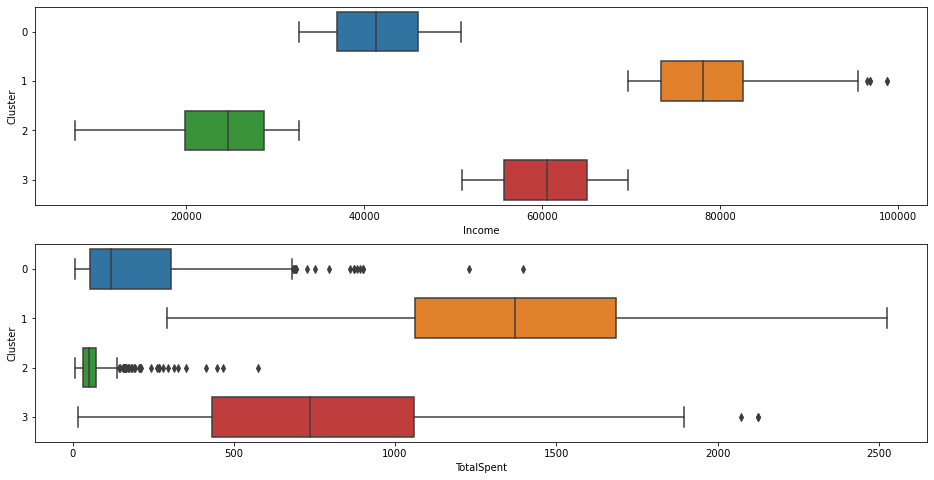

In [16]:
# Boxplots for the Features against the Clusters
f, axes = plt.subplots(2, 1, figsize=(16,8))
sb.boxplot(x = 'Income', y = 'Cluster', data = X_labeled, ax = axes[0])
sb.boxplot(x = 'TotalSpent', y = 'Cluster', data = X_labeled, ax = axes[1])

From this boxplot, you can see that in general, the higher the customer's income, the more they are likely to spend at the shop.

# Implementing Anomaly detection using Isolation Forest

Now that we tried using nearest neighbours and K means, we will repeat the same process using different algorithms

Isolation forest, similar to nearest neighbors, can be used to detect anomalies in a dataset. It identifies anomalies by isolating outliers in the data.

Isolation forest repeatedly generates partitions and then randomly selecting split values for the feature, creating a tree. The anomalies will be the points that have a shorter path to the tree

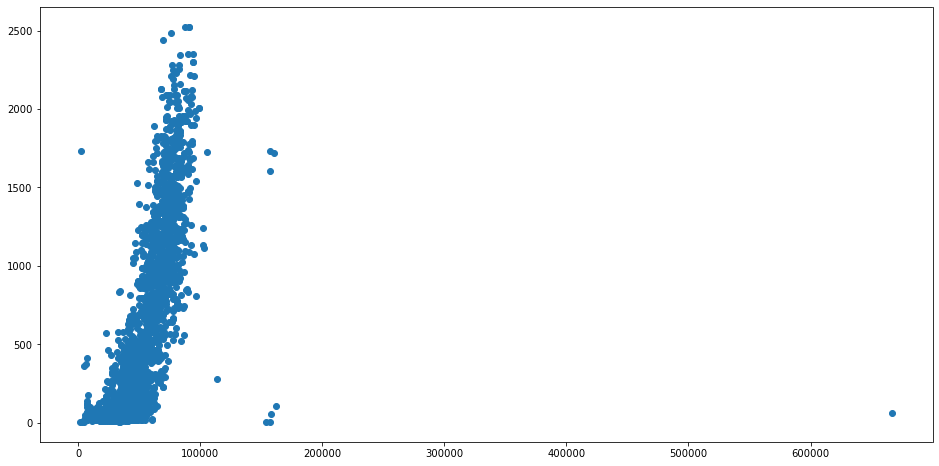

In [17]:
# Extract the Features from the Data
X = pd.DataFrame(marketdata[["Income", "TotalSpent"]])
# Plot the Raw Data on a 2D grid
f, axes = plt.subplots(1, 1, figsize=(16,8))
plt.scatter(x = "Income", y = "TotalSpent", data = X)

In [18]:
# Import IsolationForest from sklearn.ensemble
from sklearn.ensemble import IsolationForest

clf = IsolationForest(random_state=0,contamination=float(0.04))
clf.fit(X)

IsolationForest(contamination=0.04, random_state=0)

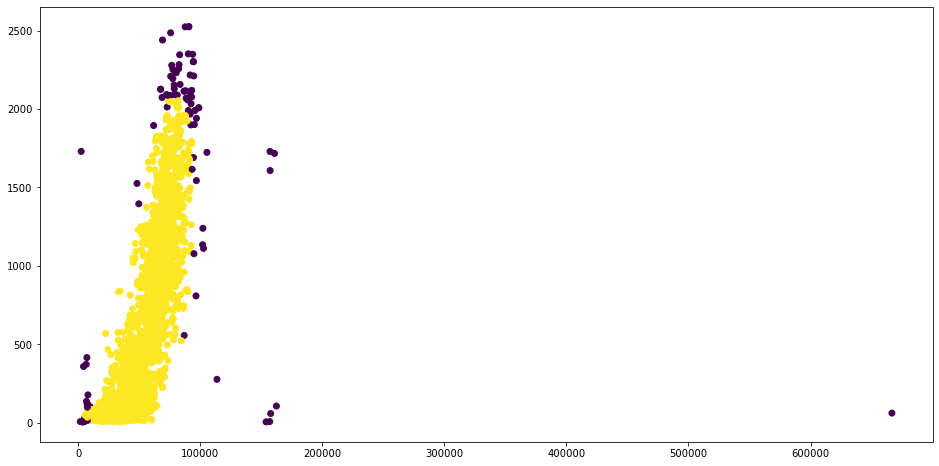

In [19]:
# Predict the Cluster Labels
labels = clf.fit_predict(X)

# Append Labels to the Data
X_labeled_forest = X.copy()
X_labeled_forest["Cluster"] = pd.Categorical(labels)


# Visualize the Clusters in the Data
f, axes = plt.subplots(1, 1, figsize=(16,8))
plt.scatter(x = "Income", y = "TotalSpent", c = "Cluster", cmap = 'viridis', data = X_labeled_forest)

In [20]:
X_labeled_forest.head()

,Income,TotalSpent,Cluster
0,84835.0,1190,1
1,57091.0,577,1
2,67267.0,251,1
3,32474.0,11,1
4,21474.0,91,1


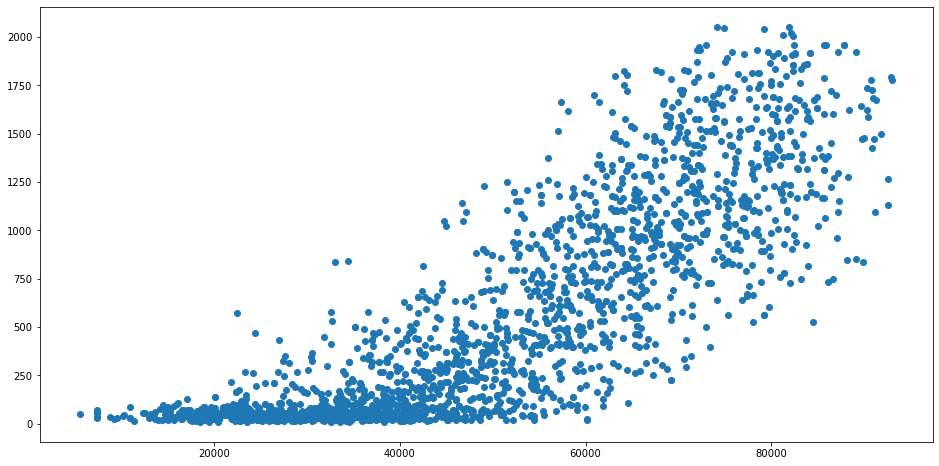

In [21]:
# Iterate through the rows and find which are the anomalies
for index,row in X_labeled_forest.iterrows():
    # -1 are all the anomalies
    if row["Cluster"] == -1:
        # Drop all the anomalies to "clean the data"
        X_labeled_forest = X_labeled_forest.drop(index)

# Plot the "Cleaned" data for visualization
f, axes = plt.subplots(1, 1, figsize=(16,8))        
plt.scatter(x = "Income", y = "TotalSpent", cmap = 'viridis', data = X_labeled_forest)

This yields a similar result to local outlier algorithm

# Implementing Bi-Variate Clustering using Hierachical Clustering

We will be using the data "cleaned" of anomalies using isolation forest above. Instead of K-means, we will be implementing Hierachical clustering to identify clusters instead.

The main difference between hierachical clustering and K means clustering is that hierachical clustering starts with individual points and clusters them into one, while K means starts with the whole dataset and splits them off.


We will be using the dendogram to determine a good number of clusters.

In [22]:
X_hc= pd.DataFrame(X_labeled_forest[["TotalSpent","Income"]])
X_hc.head()

,TotalSpent,Income
0,1190,84835.0
1,577,57091.0
2,251,67267.0
3,11,32474.0
4,91,21474.0


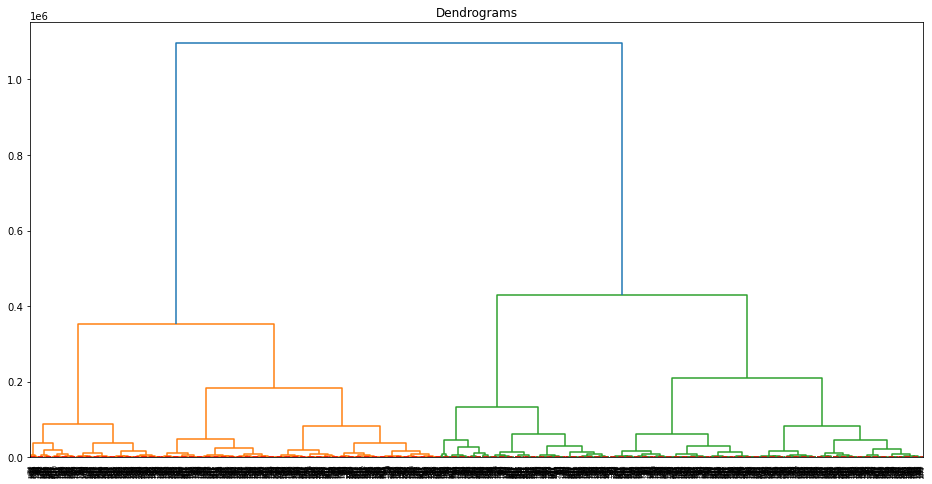

In [23]:
import scipy.cluster.hierarchy as shc
plt.figure(figsize=(16, 8))  
plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(X_hc, method='ward'))
plt.axhline(y=0.3, color='r', linestyle='--')

Similar to the Elbow Plot in K-Means, we can use the dendogram to determine the amount of clusters. For the dendogram, we will determine the number by drawing a horizontal line across the dendogram. The line with the longest distance before a merger is at around y = 0.3 . Since y = 0.3 cuts 4 lines, we will choose K = 4.

In [24]:
from sklearn.cluster import AgglomerativeClustering
X = X_hc
cluster = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward')  
labels = cluster.fit_predict(X)

/Users/loissen/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


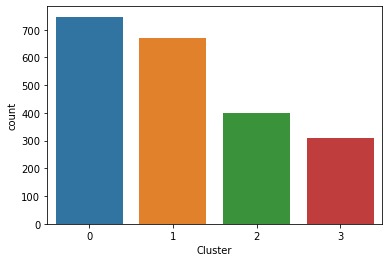

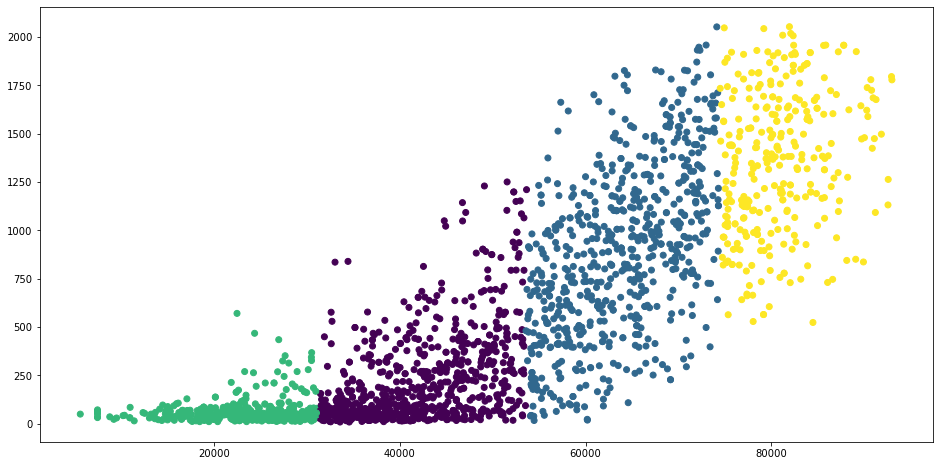

In [25]:
# Append Labels to the Data
X_labeled = X.copy()
X_labeled["Cluster"] = pd.Categorical(labels)

# Summary of the Cluster Labels
sb.countplot(X_labeled["Cluster"])

# Visualize the Clusters in the Data
f, axes = plt.subplots(1, 1, figsize=(16,8))
plt.scatter(x = "Income", y = "TotalSpent", c = "Cluster", cmap = 'viridis', data = X_labeled)

# Conclusion
Clustering is a fundamental and important aspect of unsupervised machine learning that can be used to identify trends. This is especially useful for exploring data sets to find trends and patterns.